In [1]:
!git clone --depth=1 https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python.git
!pip install filterpy

Cloning into 'Kalman-and-Bayesian-Filters-in-Python'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 170 (delta 5), reused 90 (delta 2), pack-reused 0
Receiving objects: 100% (170/170), 20.11 MiB | 20.71 MiB/s, done.
Resolving deltas: 100% (5/5), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 3.7 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=e7fc02e580b50d8165ac40189a0c4b73f9de8c8745068bbe49e55c7aff8ebff6
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [2]:
cd /kaggle/working/Kalman-and-Bayesian-Filters-in-Python/

/kaggle/working/Kalman-and-Bayesian-Filters-in-Python


In [3]:
#format the book
import book_format
book_format.set_style()

In [4]:
cd /kaggle/working/Kalman-and-Bayesian-Filters-in-Python/kf_book

/kaggle/working/Kalman-and-Bayesian-Filters-in-Python/kf_book


In [5]:
import numpy as np
belief = np.array([1/10]*10)
print(belief)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [6]:
hallway = np.array([1,1,0,0,0,0,0,0,1,0])

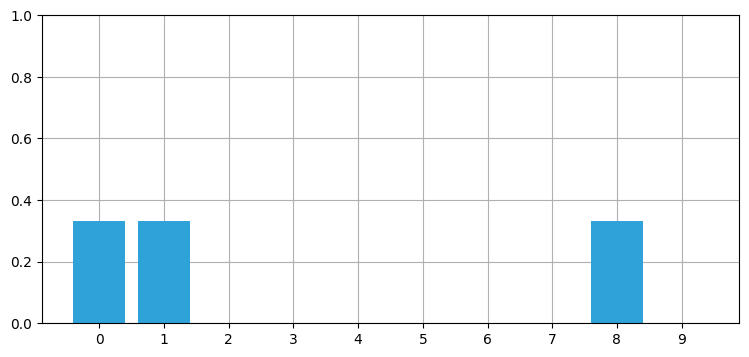

In [7]:
import kf_book.book_plots as book_plots
from kf_book.book_plots import figsize, set_figsize
import matplotlib.pyplot as plt

belief = np.array([1/3,1/3,0,0,0,0,0,0,1/3,0])
book_plots.bar_plot(belief)

In [8]:
belief = hallway *(1/3)
print(belief)

[0.333 0.333 0.    0.    0.    0.    0.    0.    0.333 0.   ]


In [9]:
belief = np.array([0., 1., 0., 0.,0., 0.,0., 0.,0., 0., ])

信念: [0.3 0.3 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.1]
和= 1.6000000000000003


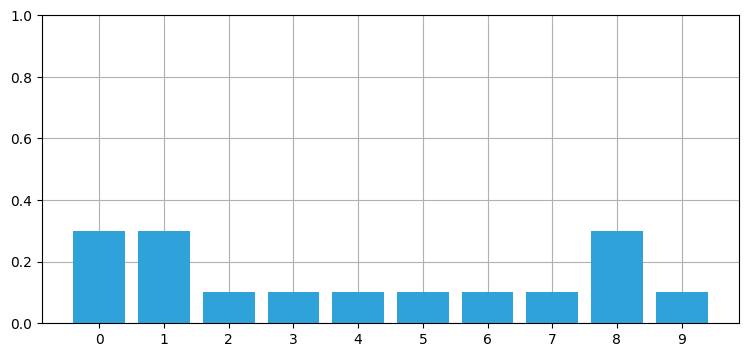

In [10]:
def update_belief(hall, belief, z, correct_scale):
    for i, val in enumerate(hall):
        if val == z:
            belief[i] *= correct_scale
            
belief = np.array([0.1]*10)
reading = 1   # 1 = 「ドア」
update_belief(hallway, belief, z=reading, correct_scale=3.)
print('信念:', belief)
print('和=', sum(belief))
plt.figure()
book_plots.bar_plot(belief)

In [11]:
belief / sum(belief)

array([0.188, 0.188, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.188,
       0.062])

In [12]:
from filterpy.discrete_bayes import normalize
normalize(belief)

array([0.188, 0.188, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.188,
       0.062])

In [13]:
hallway ==1

array([ True,  True, False, False, False, False, False, False,  True,
       False])

和= 1.0
ドアの確率= 0.1875
壁の確率= 0.06249999999999999


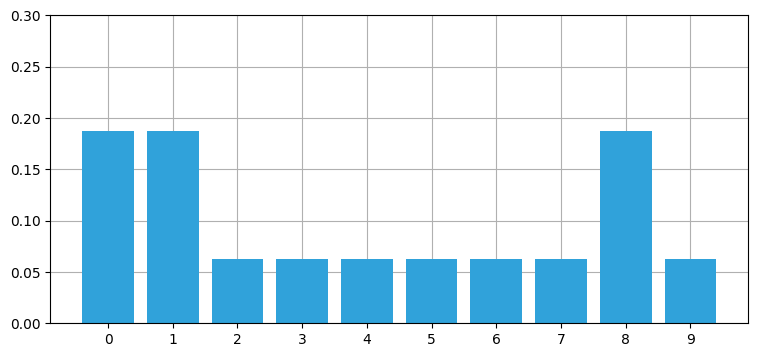

In [14]:
def scaled_update(hall, belief, z, z_prob):
    scale =z_prob / (1. - z_prob)
    belief[hall==z] *= scale
    normalize(belief)
    
belief = np.array([0.1] * 10)
scaled_update(hallway, belief, z=1, z_prob=.75)

print('和=', sum(belief))
print('ドアの確率=', belief[0])
print('壁の確率=', belief[2])
book_plots.bar_plot(belief, ylim=(0, .3))

In [15]:
def scaled_update(hall, belief, z, z_prob):
    scale = z_prob / (1. - z_prob)
    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return normalize(likelihood * belief)

In [16]:
def update(likelihood, prior):
    return normalize(likelihood * prior)

In [17]:
from filterpy.discrete_bayes import update

def lh_hallway(hall, z, z_prob):
    """計測値が廊下の各位置にマッチする尤度を計算する。"""
    
    try:
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError:
        scale = 1e8
        
    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return likelihood

belief = np.array([0.1]*10)
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
update(likelihood, belief)

array([0.188, 0.188, 0.062, 0.062, 0.062, 0.062, 0.062, 0.062, 0.188,
       0.062])

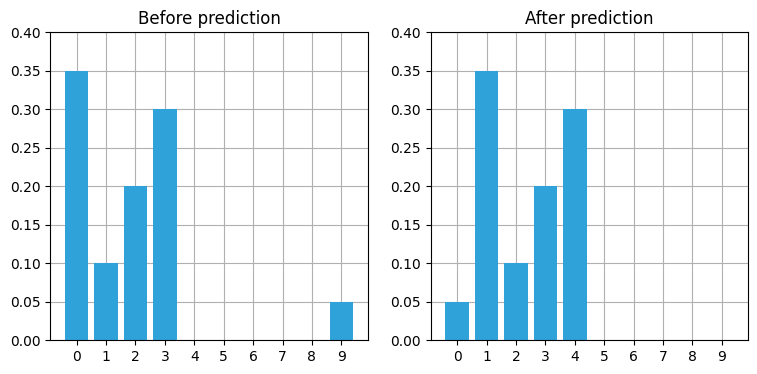

In [18]:
def perfect_predict(belief, move):
    """
    move が非負なら、位置を move 個だけ右に動かす。
    move が負なら、皮膚を -move 個だけ左に動かす。
    """
    n = len(belief)
    result = np.zeros(n)
    for i in range(n):
        result[i] = belief[(i-move)% n]
    return result

belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
plt.subplot(121)
book_plots.bar_plot(belief, title='Before prediction', ylim=(0, .4))

belief = perfect_predict(belief, 1)
plt.subplot(122)
book_plots.bar_plot(belief, title='After prediction', ylim=(0, .4))

In [19]:
from ipywidgets import interact, IntSlider

belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
perfect_beliefs = []

for _ in range(20):
    # サイモンが位置一つ分だけ右に移動する
    belief = perfect_predict(belief, 1)
    perfect_beliefs.append(belief)
    
def simulate(time_step):
    book_plots.bar_plot(perfect_beliefs[time_step], ylim=(0, .4))
    plt.show()
    
interact(simulate, time_step=IntSlider(value=0, max=len(perfect_beliefs)-1));

interactive(children=(IntSlider(value=0, description='time_step', max=19), Output()), _dom_classes=('widget-in…

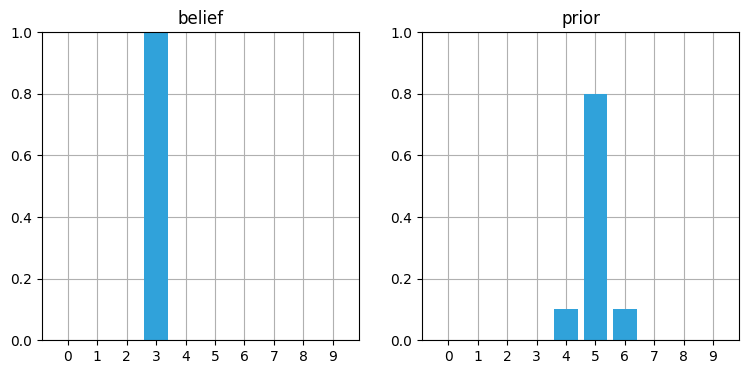

In [20]:
def predict_move(belief, move, p_under, p_correct, p_over):
    n = len(belief)
    prior = np.zeros(n)
    for i in range(n):
        prior[i] = (
             belief[(i-move) % n] * p_correct +
             belief[(i-move-1) % n] * p_over +
             belief[(i-move+1) % n] * p_under)
    return prior


belief = [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]
prior = predict_move(belief, 2, .1, .8, .1)
book_plots.plot_belief_vs_prior(belief, prior)

信念は最初にいる位置を100%確信していることを示す。

array([0.  , 0.  , 0.  , 0.04, 0.38, 0.52, 0.06, 0.  , 0.  , 0.  ])

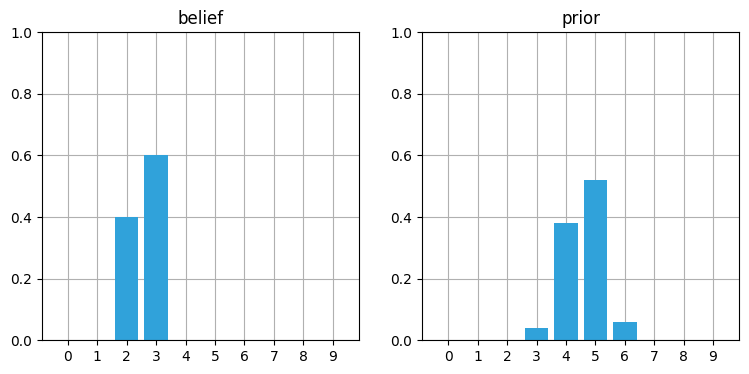

In [21]:
belief = [0, 0, .4, .6, 0, 0, 0, 0, 0, 0, ]
prior = predict_move(belief, 2, .1, .8, .1)
book_plots.plot_belief_vs_prior(belief, prior)
prior

信念は2と3の位置に0.4と0.6の確率でいることを確信している。

In [22]:
belief = np.array([1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
predict_beliefs = []

for i in range(100):
    belief = predict_move(belief, 1, .1, .8, .1)
    predict_beliefs.append(belief)
    
print('最後の信念:', belief)

# プロットを対話的にする。
def show_prior(step):
    book_plots.bar_plot(predict_beliefs[step-1])
    plt.title(f'Step {step}')
    plt.show()
    
interact(show_prior, step=IntSlider(value=1, max=len(predict_beliefs)));

最後の信念: [0.104 0.103 0.101 0.099 0.097 0.096 0.097 0.099 0.101 0.103]


interactive(children=(IntSlider(value=1, description='step'), Output()), _dom_classes=('widget-interact',))

In [23]:
print('最終的な信念:', belief)

最終的な信念: [0.104 0.103 0.101 0.099 0.097 0.096 0.097 0.099 0.101 0.103]


In [24]:
def predict_move_convolution(pdf, offset, kernel):
    N = len(pdf)
    kN = len(kernel)
    width = int((kN - 1)/ 2)
    
    prior = np.zeros(N)
    for i in range(N):
        index = (i + (k-width) - offset) % N
        prior[i] += pdf[index] * kernel[k]
    return prior

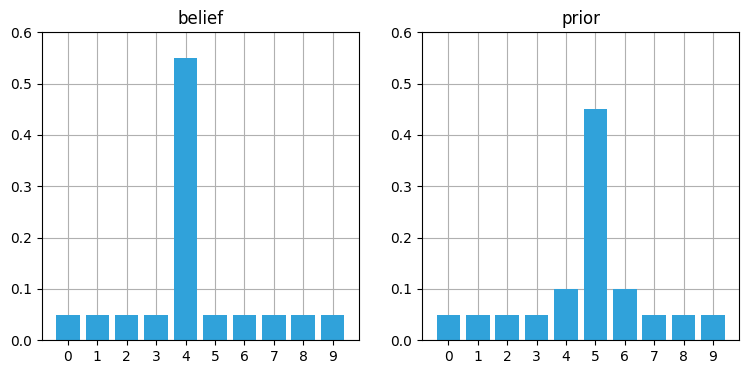

In [25]:
from filterpy.discrete_bayes import predict

belief = [.05, .05, .05, .05, .55, .05, .05, .05, .05,.05]
prior = predict(belief, offset=1, kernel=[.1, .8, .1])
book_plots.plot_belief_vs_prior(belief, prior, ylim=(0, 0.6))

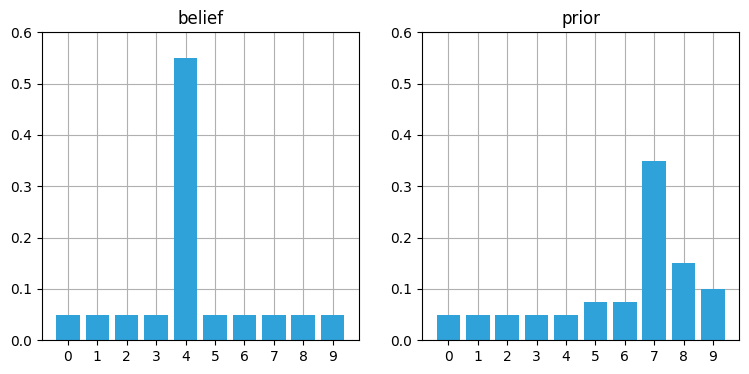

In [26]:
prior = predict(belief, offset=3, kernel=[.05, .05,.6, .2, .1])
book_plots.plot_belief_vs_prior(belief, prior, ylim=(0, 0.6))

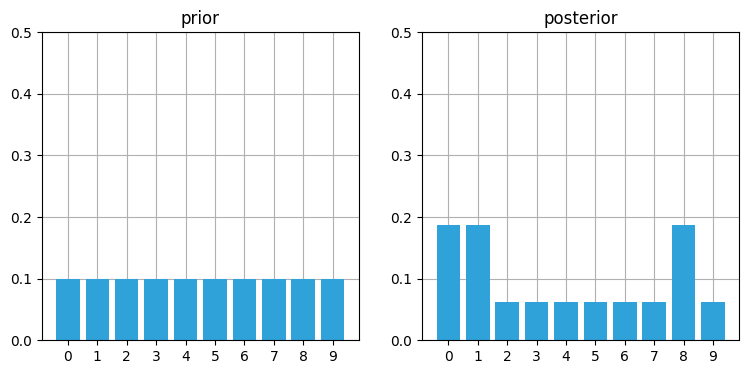

In [27]:
from filterpy.discrete_bayes import update

hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
prior = np.array([.1] * 10)
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0, .5))

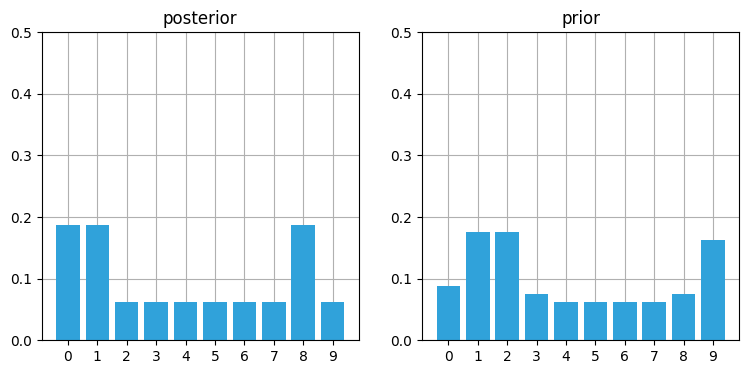

In [28]:
kernel = (.1, .8, .1)
prior = predict(posterior, 1, kernel)
book_plots.plot_prior_vs_posterior(prior, posterior, True, ylim=(0, .5))

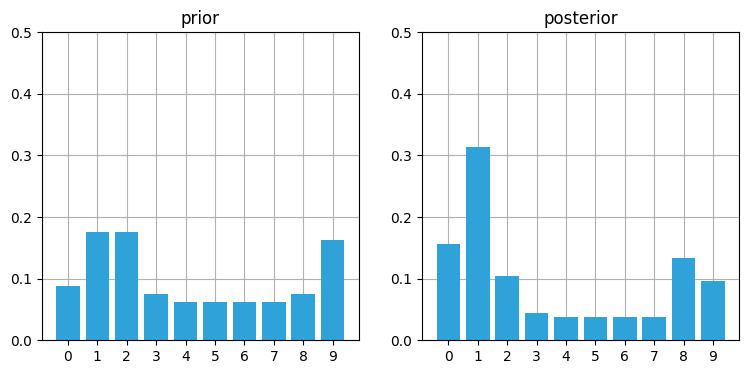

In [29]:
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0, .5))

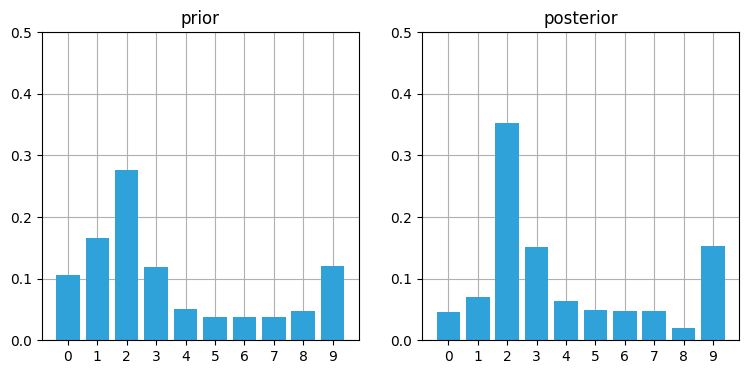

In [30]:
prior = predict(posterior, 1, kernel)
likelihood = lh_hallway(hallway, z=0, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0, .5))

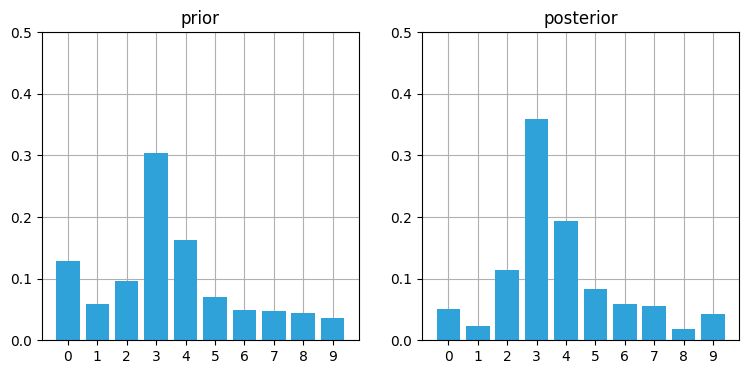

In [31]:
prior = predict(posterior, 1, kernel)
likelihood = lh_hallway(hallway, z=0, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0, .5))